<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../')) 

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import math

from super_simulation.super_simulation_factory import SuperSimulationFactory
from transition_table import TransitionTable
from spark_policy import SparkPolicy
from utils.spark_bq_utils import upload_spark_model_inputs
import pandas as pd
from functools import partial
from scipy.stats import bootstrap
from scipy.stats import lognorm


pd.set_option('display.max_rows', 500)

In [2]:
# load population data

total_pop = pd.read_csv("../state/CA/CA_total_pop_by_crime_category.csv")
total_pop = total_pop.iloc[:, :6]

# load admissions data

admissions = pd.read_csv("../state/CA/CA_admissions_by_crime_category.csv")
admissions = admissions.iloc[:, :6]

Preprocess the data: make sure that the data types are right, the numbers are formatted properly, deal with missing values, etc.

In [4]:
# create month and year columns for total_pop

month_year = total_pop.Date.str.split(" " , n=1, expand = True)
total_pop["Month"], total_pop["Year"] = month_year.iloc[:, 0], month_year.iloc[:, 1]
total_pop = total_pop.drop("Date", axis = 1)

total_pop.Month = total_pop.index % 12 + 1

# another way to do this:
# month_to_number = {"January": 1, "February": 2, ...}
# total_pop.Month = total_pop.Month.map(month_to_number)

# a third way to do this:
# for i in range (len(total_pop)): 
#    total_pop.iloc[i,5] = i % 12 + 1

# create month and year columns for admissions table

month_year_admissions = admissions.Date.str.split(" " , n=1, expand = True)
admissions["Month"], admissions["Year"] = month_year_admissions.iloc[:, 0], month_year_admissions.iloc[:, 1]
admissions = admissions.drop("Date", axis = 1)

admissions.Month = admissions.index % 12 + 1

In [5]:
# remove commas from columns

def remove_commas(df, column_name):
    df[f"{column_name}"] = df[f"{column_name}"].apply(lambda x: x.replace(",", ""))

remove_commas(total_pop, "Crimes Against Persons")
remove_commas(total_pop, "Property Crimes")
remove_commas(total_pop, "Drug Crimes")
remove_commas(total_pop, "Other Crimes")

remove_commas(admissions, "Crimes Against Persons")
remove_commas(admissions, "Property Crimes")
remove_commas(admissions, "Drug Crimes")
remove_commas(admissions, "Other Crimes")

In [6]:
# check data types of columns in each df

total_pop.dtypes
admissions.dtypes

Crimes Against Persons    object
Property Crimes           object
Drug Crimes               object
Other Crimes              object
Missing                   object
Month                      int64
Year                      object
dtype: object

In [7]:
# change types of total_pop columns, drop Missing column

total_pop = total_pop.drop("Missing", axis=1)
total_pop = total_pop.astype(int)

# replace x's and *'s in code, drop Missing column

admissions = admissions.drop("Missing", axis=1)
admissions = admissions.replace("*", 5)
admissions = admissions.replace("x", 0)
admissions = admissions.astype(int)

<Axes: xlabel='time_step'>

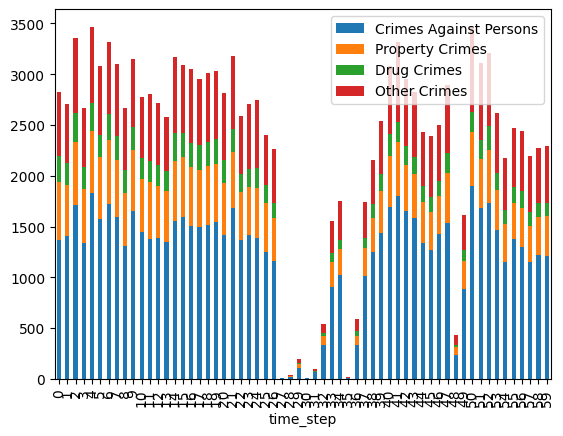

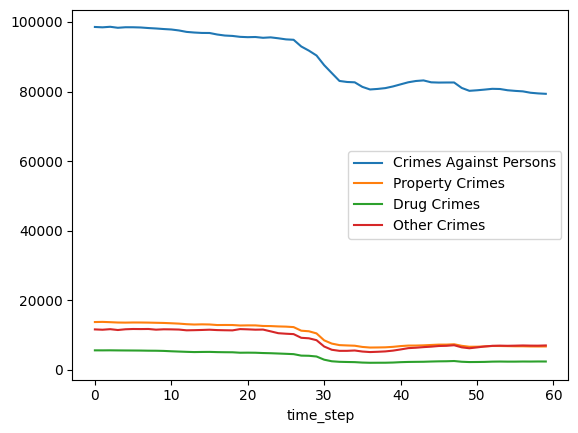

In [9]:
# add time step column, graph data

total_pop["time_step"] = total_pop.index
# total_pop_chart = total_pop.drop(["Month", "Year"], axis=1).plot.bar(x='time_step', stacked=True)

admissions["time_step"] = total_pop.index
admissions_chart = admissions.drop(["Month", "Year"], axis=1).plot.bar(x='time_step', stacked=True)

total_pop.drop(["Month", "Year"], axis=1).plot(x='time_step')

# Transitions Table

In [10]:
# how do you use total population and admissions data to get transitions data?

# total number of people
# number of people coming into prison
# goal: how long they stay in prison

# admissions * LOS = population

<Axes: >

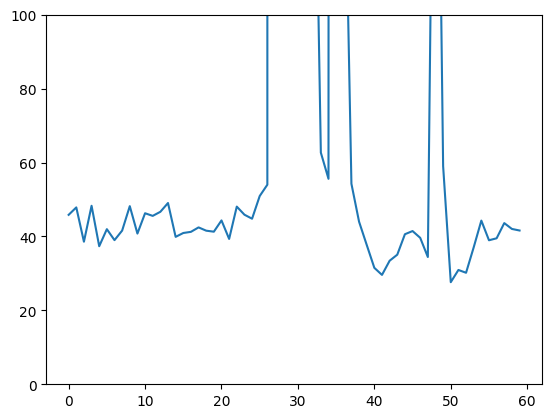

In [11]:
# original los data

los = (total_pop.iloc[:, 0:4].sum(axis=1) / admissions.iloc[:, 0:4].sum(axis=1))
los.plot(ylim = [0,100])

array([6.97594531e+00, 6.70966480e-01, 4.26142173e+00, 1.03382187e+00,
       3.66966204e+00, 5.72105284e+00, 2.23728195e-01, 3.11006930e+00,
       1.04735687e+00, 3.33171825e+00, 5.25224089e+00, 6.26227920e+00,
       1.77900449e+00, 9.45926481e-01, 1.50864482e+00, 5.46177774e+00,
       6.27490625e+00, 7.00078372e-02, 1.83313576e+00, 6.07829642e-01,
       3.46718590e+00, 8.14788503e+00, 1.23841509e+00, 1.12171298e+00,
       2.32163769e+00, 1.86144702e+01, 1.29805143e+00, 4.79448595e+00,
       2.23160699e+00, 8.36772578e-01, 3.92237513e+00, 1.84456306e+00,
       2.70451381e+00, 1.49781028e+00, 4.39610819e+00, 8.35996455e+00,
       2.16824161e+00, 2.70663132e+00, 4.15131097e+00, 7.66682902e+00,
       8.24942373e+00, 2.74649928e+00, 4.33617114e+00, 4.12582912e+00,
       4.50559157e+00, 6.43109843e-01, 4.12721574e+00, 2.92042558e+00,
       9.05959821e+00, 2.02420857e+00, 3.36525854e+00, 7.79389337e+00,
       1.36284948e+00, 3.24340973e+00, 6.63669099e+00, 1.17955696e+01,
      

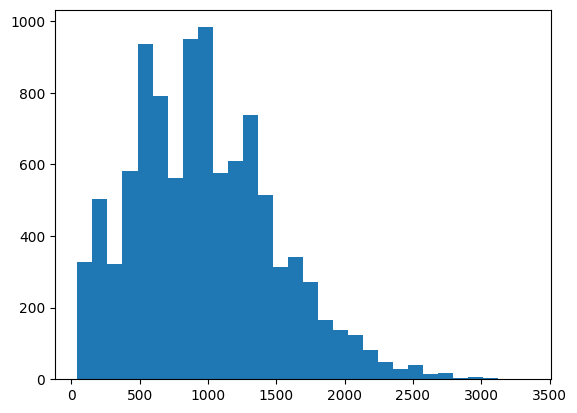

In [14]:
# bootstrap length of stay data to reduce biasing effects of the two big spikes around time step 30 and 50

los = (los,)

bootstrap_ci = bootstrap(los, np.mean, confidence_level=0.95,
                         random_state=1, method='percentile')
plt.hist(bootstrap_ci.bootstrap_distribution, bins=30)
std_err = bootstrap_ci.standard_error
lognorm.rvs(s=1, scale=np.math.exp(1), size=1000)

In [15]:
# this cell gets an avg LOS for each crime type using the formula
# LOS(t-1) = total_pop(t-1) / admissions - delta(total_pop(t))
# delta(total_pop(t)) = total_pop(t) - total_pop(t - 1)

pop_sum = total_pop.iloc[:, 0:4]
pop_sum_t = pop_sum[1:]
pop_sum_previous = pop_sum[:-1]
admissions_total = admissions.iloc[1:, 0:4]
los = pop_sum_previous.reset_index(drop=True) / (admissions_total.reset_index(drop=True)
      + pop_sum_previous.reset_index(drop=True) - pop_sum_t.reset_index(drop=True))

In [16]:
# combine bootstrapped data and avg LOS for each crime type to create transitions per crime type

crimes_against_persons_los = (los["Crimes Against Persons"],)
bootstrap_ci_cap = bootstrap(crimes_against_persons_los, np.mean, confidence_level=0.95,
                          random_state=1, method='percentile')
cap_transitions = bootstrap_ci_cap.bootstrap_distribution         

property_crimes_los = (los["Property Crimes"],)
bootstrap_ci_prop = bootstrap(property_crimes_los, np.mean, confidence_level=0.95,
                          random_state=1, method='percentile')
prop_transitions = bootstrap_ci_prop.bootstrap_distribution 

drug_crimes_los = (los["Drug Crimes"],)
bootstrap_ci_drug = bootstrap(drug_crimes_los, np.mean, confidence_level=0.95,
                          random_state=1, method='percentile')
drug_transitions = bootstrap_ci_drug.bootstrap_distribution 

other_crimes_los = (los["Other Crimes"],)
bootstrap_ci_other = bootstrap(other_crimes_los, np.mean, confidence_level=0.95,
                          random_state=1, method='percentile')
other_transitions = bootstrap_ci_other.bootstrap_distribution 

In [17]:
# visualize the transitions data we've created

# plt.hist(cap_transitions, bins=30)
# plt.hist(prop_transitions, bins=30, alpha = 0.5)
# plt.hist(drug_transitions, bins=30, alpha = 0.5)
# plt.hist(other_transitions, bins=30, alpha = 0.5)

In [18]:
# let's create the transitions table!

transitions_data = pd.DataFrame({
    'compartment': ["prison"] * (9999 * 4) + ["release"] * 4,
    'outflow_to': ["release"] * (9999 * 4) + ["release"] * 4,
    'crime_type': (["Crimes Against Persons"] * 9999) + (["Property Crimes"] * 9999) + (["Drug Crimes"] * 9999) + (["Other Crimes"] * 9999) + ["Crimes Against Persons", "Property Crimes", "Drug Crimes", "Other Crimes"],
    'compartment_duration': list(cap_transitions) + list(prop_transitions) + list(drug_transitions) + list(other_transitions) + [1.0] * 4,
    'total_population': [1.0] * (10000 * 4)
})

transitions_data

compartment outflow_to              crime_type  compartment_duration  \
0          prison    release  Crimes Against Persons             58.537117   
1          prison    release  Crimes Against Persons             60.988930   
2          prison    release  Crimes Against Persons             60.309418   
3          prison    release  Crimes Against Persons             59.927144   
4          prison    release  Crimes Against Persons             57.197566   
...           ...        ...                     ...                   ...   
39995      prison    release            Other Crimes             16.500964   
39996     release    release  Crimes Against Persons              1.000000   
39997     release    release         Property Crimes              1.000000   
39998     release    release             Drug Crimes              1.000000   
39999     release    release            Other Crimes              1.000000   

       total_population  
0                   1.0  
1                   1.0  
2                   1.0  
3                   1.0  
4                   1.0  
...                 ...  
39995               1.0  
39996               1.0  
39997               1.0  
39998               1.0  
39999               1.0  

[40000 rows x 5 columns]

In [19]:
# old simplified transitions table

# los_avg is an old value that we used to define as the mean of the length of stays of all crime types
# transitions = pd.DataFrame({
#     'compartment': ["prison"] * 4 + ["release"] * 4,
#     'outflow_to': ["release"] * 8,
#     'crime_type': ["Crimes Against Persons", "Property Crimes", "Drug Crimes", "Other Crimes"] * 2,
#     'compartment_duration': list(los_avg) + [1.0] * 4,
#     'total_population': [1.0] * 8
# })

# transitions = transitions.reset_index().rename({'index': 'crime_type'}, axis=1)

# Outflows Table

In [20]:
# let's create the outflows table! multiple ways to do it

# way 1:
outflows_data = pd.DataFrame(
    {"compartment": ["pretrial"] * 240,
     "outflow_to": ["prison"] * 240,
     "crime_type": (["Crimes Against Persons"] * 60) + (["Property Crimes"] * 60) + (["Drug Crimes"] * 60) + (["Other Crimes"] * 60),
     "time_step": list(range(60)) * 4,
     "total_population": list(admissions["Crimes Against Persons"]) + list(admissions["Property Crimes"]) + list(admissions["Drug Crimes"]) + list(admissions["Other Crimes"]),
    }
)

outflows_data.total_population = outflows_data.total_population.astype(float)

# way 2:
# admissions.melt(
#     value_vars=["Crimes Against Persons", "Property Crimes", "Drug Crimes", "Other Crimes"],
#     id_vars=['time_step']
# )

In [22]:
# adjust the outflows table! this time, we replaced COVID data (4/2020 to 4/2021) with a flat average
# two different ways of doing the same thing

# way 1: 
# find average total population per crime type for non-COVID years only
outflows_data = outflows_data[(outflows_data.time_step < 27) | (outflows_data.time_step >= 39)]
means = outflows_data.groupby("crime_type").mean()
cap_mean = means.loc["Crimes Against Persons"].total_population
prop_mean = means.loc["Property Crimes"].total_population
drug_mean = means.loc["Drug Crimes"].total_population
other_mean = means.loc["Other Crimes"].total_population

# create dataframe to store new flat rate data for the COVID years
outflows_data_add = pd.DataFrame(
     {"compartment": ["pretrial"] * 48,
     "outflow_to": ["prison"] * 48,
     "crime_type": (["Crimes Against Persons"] * 12) + (["Property Crimes"] * 12) + (["Drug Crimes"] * 12) + (["Other Crimes"] * 12),
     "time_step": list(range(27, 39)) * 4,
     "total_population": [cap_mean] * 12 + [prop_mean] * 12 + [drug_mean] * 12 + [other_mean] * 12,
    }   
)

# combine the two dataframes to make new outflows table
outflows_data = outflows_data.append(outflows_data_add)

# way 2:
# m = means.total_population
# new_outflows = outflows.copy()
# for crime_type in means.index:
#     new_outflows.loc[
#         (new_outflows.crime_type == crime_type) 
#         & (new_outflows.time_step >= 27) 
#         & (new_outflows.time_step < 39),
#         'total_population'
#     ] = m[crime_type]

# new_outflows.groupby(['time_step', 'crime_type']).sum().unstack('crime_type').plot()

/var/folders/2b/1mk8fdhx1_n4721rb_xg8x4h0000gn/T/ipykernel_37857/602752545.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = outflows_data.groupby("crime_type").mean()
/var/folders/2b/1mk8fdhx1_n4721rb_xg8x4h0000gn/T/ipykernel_37857/602752545.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outflows_data = outflows_data.append(outflows_data_add)


# Total Population Table

In [23]:
# create total population table

total_population_data = pd.DataFrame({
    'compartment': ['prison'] * 240,
    'time_step': list(range(60)) * 4,
    'crime_type': (["Crimes Against Persons"] * 60) + (["Property Crimes"] * 60) + (["Drug Crimes"] * 60) + (["Other Crimes"] * 60),
    'total_population': list(total_pop['Crimes Against Persons']) + list(total_pop['Property Crimes']) + list(total_pop['Drug Crimes']) + list(total_pop['Other Crimes'])
})

total_population_data.total_population = total_population_data.total_population.astype(float)

# Run a Baseline Scenario

In [41]:
# STEP 1: pick a `simulation_tag` for your simulation. "paco_parole_test" would be a reasonable example...
simulation_tag = "ca_sb81"

upload_spark_model_inputs(
    "recidiviz-staging",
    simulation_tag,
    outflows_data,
    transitions_data,
    total_population_data,
    '../state/CA/ca_preprocessing_model_inputs.yml',
)

In [42]:
# Don't worry about any warnings, as long as this doesn't fail you're in business
spark_sim = SuperSimulationFactory.build_super_simulation(
    '../state/CA/ca_preprocessing_model_inputs.yml'
)

/Users/ayeshakhawaja/.local/share/virtualenvs/stanford-decarceration-collective-2t2SjLv5/lib/python3.8/site-packages/google/cloud/bigquery/table.py:2007: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(
/Users/ayeshakhawaja/.local/share/virtualenvs/stanford-decarceration-collective-2t2SjLv5/lib/python3.8/site-packages/google/cloud/bigquery/table.py:2007: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(
/Users/ayeshakhawaja/.local/share/virtualenvs/stanford-decarceration-collective-2t2SjLv5/lib/python3.8/site-packages/google/cloud/bigquery/table.py:2007: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation_factory.py:160: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for simulation_group_name, _ in transitions_data.groupby(disaggregation_axes):


initialization time:  3.0585408210754395


/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/aye

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/aye

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

simulation_time:  13.137508153915405


/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../super_simulation/simulator.py:269: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  simulation_results = simulation_results.groupby(


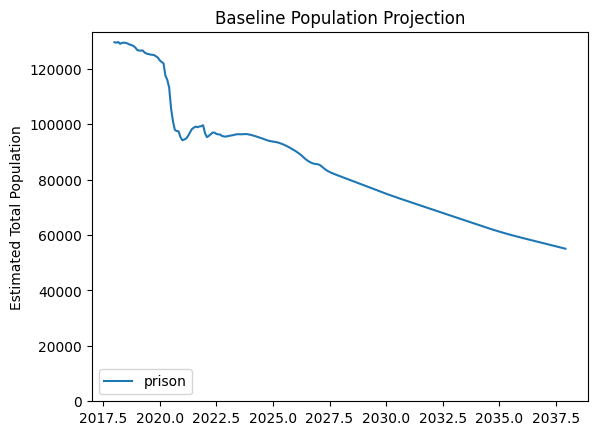

In [43]:
# This can take several minutes to run. You'll see six checkpoints printed out along the way before it finishes.
display_compartments = ['prison']
spark_sim.simulate_baseline(display_compartments) # actually runs the baseline

In [44]:
# tells us which simulations have been run
spark_sim.simulator.pop_simulations

{'baseline_projections': <population_simulation.population_simulation.PopulationSimulation at 0x2835684f0>}

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:312: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  arima_output_df = arima_output_df.append(output_df_sub)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:312: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  arima_output_df = arima_output_df.append(output_df_sub)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation.py:312: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

[<Axes: title={'center': 'simulation_group: Crimes Against Persons\ncompartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>,
 <Axes: title={'center': 'simulation_group: Drug Crimes\ncompartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>,
 <Axes: title={'center': 'simulation_group: Other Crimes\ncompartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>,
 <Axes: title={'center': 'simulation_group: Property Crimes\ncompartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>]

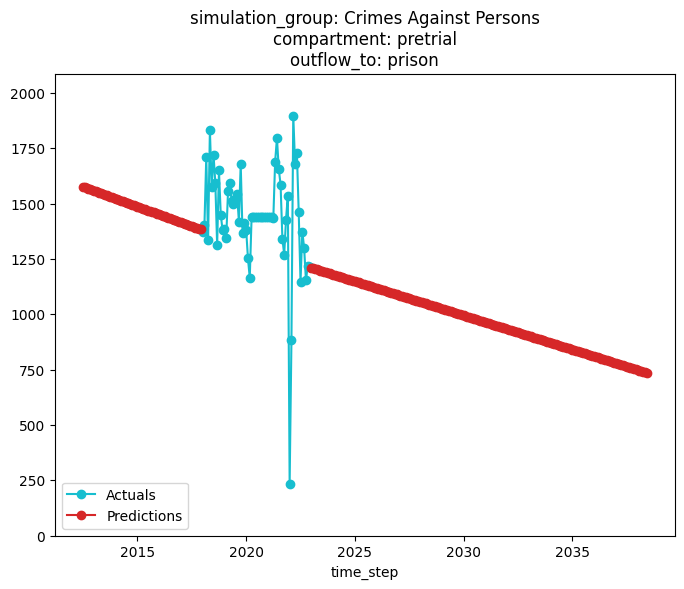

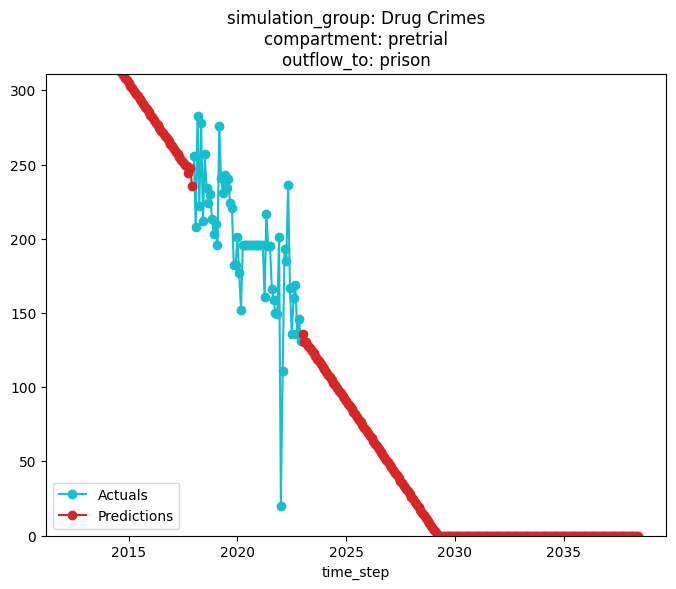

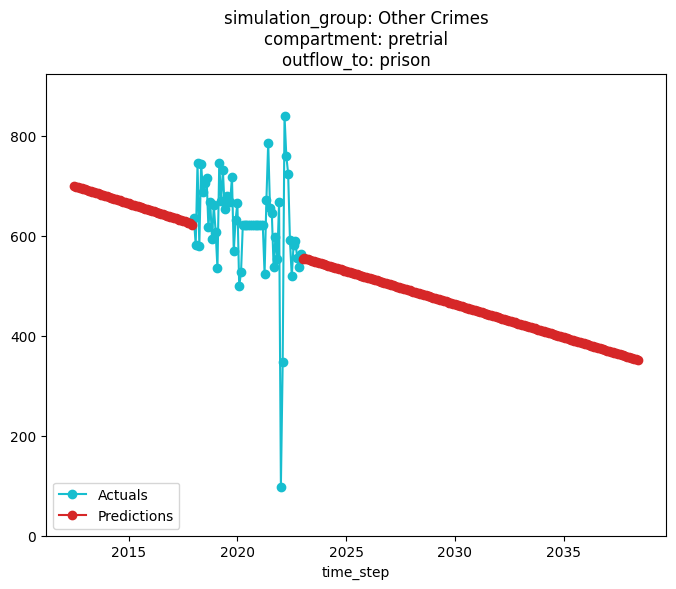

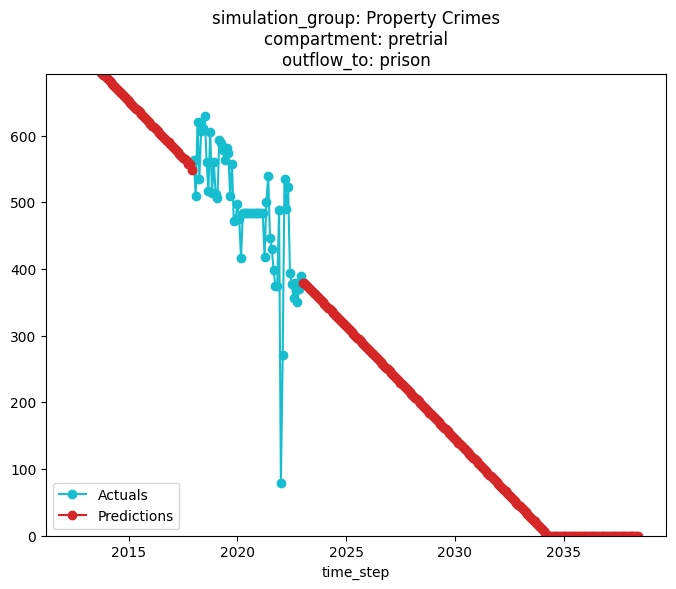

In [45]:
# let's us see how our predictions line up with the actual data
spark_sim.get_arima_output_plots('baseline_projections', by_simulation_group= True)

# Run Policy Scenario

We tried modeling this with the apply_reductions function using dummy numbers, but we couldn't find a good way to calculate the LOS reduction or the affected fraction.

In [47]:
help(TransitionTable.apply_reductions)

# LOS_REDUCTION = 0.7
# AFFECTED_FRACTION = 0.6
# REDUCTION_TYPE = '*' # This should either be '*' or '+'. If you make it '+', it will change compartment_duration L to
#                      # L - LOS_REDUCTION. If you make it '*', it will change L to L * (1 - LOS_REDUCTION)
# RETROACTIVE = False

# def apply_reduced_parole():
#     return partial(TransitionTable.apply_reductions, 
#                    reduction_df=pd.DataFrame({
#                        'outflow': 'release',
#                        'reduction_size': [LOS_REDUCTION], 
#                        'affected_fraction': [AFFECTED_FRACTION]
#                    }),
#                    reduction_type=REDUCTION_TYPE,
#                    retroactive=RETROACTIVE)

# policy_list = [SparkPolicy(policy_fn=apply_reduced_parole(),
#                                            spark_compartment='prison',
#                                            sub_population={'crime_type': 'Crimes Against Persons'},
#                                            policy_ts=24,
#                                            apply_retroactive=RETROACTIVE),
#                SparkPolicy(policy_fn=apply_reduced_parole(),
#                                            spark_compartment='prison',
#                                            sub_population={'crime_type': 'Drug Crimes'},
#                                            policy_ts=24,
#                                            apply_retroactive=RETROACTIVE),
#                SparkPolicy(policy_fn=apply_reduced_parole(),
#                                            spark_compartment='prison',
#                                            sub_population={'crime_type': 'Property Crimes'},
#                                            policy_ts=24,
#                                            apply_retroactive=RETROACTIVE),
#                SparkPolicy(policy_fn=apply_reduced_parole(),
#                                            spark_compartment='prison',
#                                            sub_population={'crime_type': 'Other Crimes'},
#                                            policy_ts=24,
#                                            apply_retroactive=RETROACTIVE)]
    
# test_results = spark_sim.simulate_policy(policy_list, 'prison')

Instead of using apply_reductions, we created an alternate transitions table by iterating through the transitions data and applying the grant rate to a subset of the population each time. Some people will get parole after their first time applying, some will get parole after their second time applying, etc. This table should represent that.

In [48]:
transitions_data['compartment_duration'] = transitions_data['compartment_duration'].round()
rounded_transitions = transitions_data.groupby(['compartment_duration', 'compartment', 'crime_type']).sum()
rounded_transitions = rounded_transitions.reset_index()

In [113]:
# an estimate! subject to change
GRANT_RATE = 0.01

# CDCR says that people must wait two years before reapplying for parole
SETOFF_TIME = 24
alternate_transitions_data = pd.DataFrame()

crime_types = ['Crimes Against Persons', 'Other Crimes', 'Property Crimes', 'Drug Crimes']

for crime_type in crime_types: # we're treating each crime type the same
    
    # isolate the transitions data just for prison and for this crime type
    crime_data = rounded_transitions[
        (rounded_transitions['crime_type'] == crime_type) 
        & (rounded_transitions['compartment'] == 'prison')
    ].copy()
    crime_data_jr = pd.DataFrame()
    
    # manually transition people out of prison with a frequency of GRANT_RATE
    for sentence_length in crime_data.compartment_duration:
        
        SENTENCE_LENGTH = math.ceil(sentence_length * (1/3))
        currently_sentenced = crime_data.loc[
            crime_data["compartment_duration"] == sentence_length
        ]
        currently_sentenced["outflow_to"] = "release"
        remaining_population = currently_sentenced["total_population"].sum()
        
        last_apply = int(min(sentence_length, SENTENCE_LENGTH + SETOFF_TIME * 4))
        for i in range(SENTENCE_LENGTH, last_apply, SETOFF_TIME):
            rate = GRANT_RATE
            
            eligible = rate * remaining_population
            currently_sentenced.loc[
                currently_sentenced["compartment_duration"] == sentence_length,
                "total_population"] *= 1 - rate            

            # add in rows of data for the people being released because they get parole
            currently_sentenced = currently_sentenced.append({
                'compartment_duration': i,
                'total_population': eligible,
                'crime_type': crime_type,
                'compartment': 'prison',
                'outflow_to': 'release'
            }, ignore_index=True)
            
            remaining_population -= eligible
            
        crime_data_jr = crime_data_jr.append(currently_sentenced)
        
    crime_data_jr = crime_data_jr.groupby([
        'compartment', 'compartment_duration', 'crime_type', 'outflow_to'
    ], as_index=False).sum()
    
    # in case the model breaks because the max LOS gets shorter in the new data
    crime_data_jr.loc[max(crime_data_jr.index), 'total_population'] = max(crime_data_jr.loc[max(crime_data_jr.index), 'total_population'], 10**(-5))
    
    # append our work to the new transitions_data we're building
    alternate_transitions_data = alternate_transitions_data.append(crime_data_jr)

# round population numbers to avoid tiny populations in weird places
alternate_transitions_data.total_population = alternate_transitions_data.total_population.apply(lambda x: round(x, 5))
# drop the rows that are now rounded to zero
alternate_transitions_data = alternate_transitions_data[alternate_transitions_data.total_population > 0]

/var/folders/2b/1mk8fdhx1_n4721rb_xg8x4h0000gn/T/ipykernel_37857/1393912626.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currently_sentenced["outflow_to"] = "release"
/var/folders/2b/1mk8fdhx1_n4721rb_xg8x4h0000gn/T/ipykernel_37857/1393912626.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currently_sentenced.loc[
/var/folders/2b/1mk8fdhx1_n4721rb_xg8x4h0000gn/T/ipykernel_37857/1393912626.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation_factory.py:160: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for simulation_group_name, _ in transitions_data.groupby(disaggregation_axes):


initialization time:  3.153568744659424


/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../population_simulation/population_simulation_factory.py:160: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for simulation_group_name, _ in transitions_data.groupby(disaggregation_axes):


initialization time:  3.0127720832824707


/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/aye

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

simulation_time:  12.763611316680908


/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/aye

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/aye

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../shell_compartment.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts] = pd.Series(outflow_dict, dtype=float)
/Users/ayeshakhawaja/Downloads/StanfordDecarcerationCollective/stanford-decarceration-collective/notebooks/../full_compartment.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows.loc[:, self.current_ts - 1] = pd.Series(outflow_dict, dtype=float)
/Users/ayesha

simulation_time:  12.742418050765991
142613.90000000002


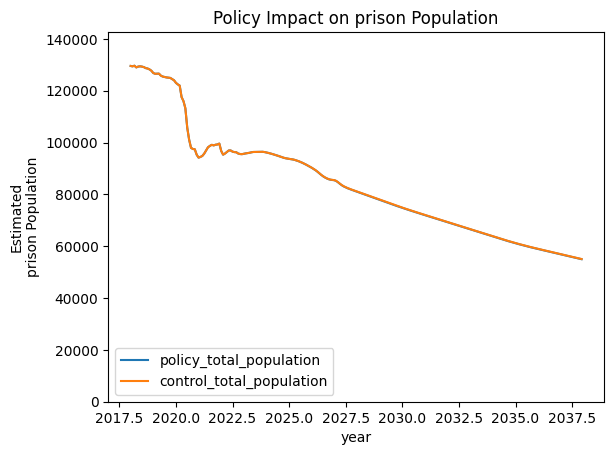

In [116]:
# policy function

def parole_increase(crime):
    return partial(
        TransitionTable.use_alternate_transitions_data, 
        alternate_historical_transitions=alternate_transitions_data[
            alternate_transitions_data.crime_type == crime
        ],
        retroactive=False
    )

policy_list = []
for crime in crime_types:
    policy_list.append(SparkPolicy(policy_fn=parole_increase(crime),
           spark_compartment='prison',
           sub_population={'crime_type': crime},
           policy_ts=66,
           apply_retroactive=False))

# run simulation
test_results = spark_sim.simulate_policy(policy_list, 'prison')